# Baseball Data Investigation

## Introduction



This project serves as an introduction into data analytics by integrating Python packages such as Pandas and Numpy to wrangle, analyze, and interpret data.  The dataset used include various files that represent the batting and pitching statistics of baseball players from 1871-2016 as well as corresponding salary data from 1985-2016. Coming from a baseball background myself, I had always found the statistical underpinnings of baseball to be fascinating.  I decided to look at the dataset from both sides of the baseball by analyzing both hitting and pitching statistics.  From the hitter's perspective, I  explored one of the endless aphorisms passed down from generations of baseball. Furthermore, when I played growing up, I was a starting pitcher, and this compelled me to do some additional analysis on starting pitchers and what makes them valuable.  Of course, value is a subjective metric, but can be tied to the salary of the pitcher without much mental effort.  With this line of reasoning, I posed the following two questions:

> ***1.  Power hitters swing for the fences and are thus more likely to strike out.  Alternatively, contact hitters strike out less since they only focus on hitting the ball.  Does this widely accepted tenet of baseball hold true. ***

>2.***What pitching statistics make a starting pitcher most valuable over the past 30 years?***



# Data Wrangling Phase

##### Data Wrangling of Batting Data
Data wrangling was done in two parts as the two questions that were posed involved entirely different statistics within the dataset.  In order to answer the first question, it was first necessary to import the batting data, which is within its own csv file.  At first I attempted to include all of the data from 1871-2016 to have a more robust dataset, but there seemed to be several missing data points for the number of strikeouts for each player pre-1913 and thus only included years past or including 1913.  This was essentially the only step necessary to filter out the batting data before the exploration phase began.  

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
batting = pd.read_csv('Batting.csv')

In [7]:
#import the batting statistics file
batting = pd.read_csv('Batting.csv')

#Separate several statistics based on the year
HR_by_year = batting.groupby('yearID')['HR'].sum()
triple_by_year = batting.groupby('yearID')['3B'].sum()
double_by_year = batting.groupby('yearID')['2B'].sum()
hits_by_year = batting.groupby('yearID')['H'].sum()
strikeouts_by_year = batting.groupby('yearID')['SO'].sum()

#to find singles, simply subtract the home runs, triples, and doubles from total hits
single_by_year = hits_by_year - HR_by_year - triple_by_year - double_by_year
AB_by_year = batting.groupby('yearID')['AB'].sum()

#need to specify only the years from 1913- present since some values in SO are NaN distorting the data
HR_by_year_revised = HR_by_year[(HR_by_year.index >= 1913)]
single_by_year_revised = single_by_year[(single_by_year.index >= 1913)]
AB_by_year_revised = AB_by_year[(AB_by_year.index >= 1913)]
SO_by_year_revised = strikeouts_by_year[(strikeouts_by_year.index >= 1913)]

#normalize each statistic based on the number of at bats for that year
HR_AB_ratio = HR_by_year_revised/AB_by_year_revised
single_AB_ratio = single_by_year_revised/AB_by_year_revised
SO_AB_ratio = SO_by_year_revised/AB_by_year_revised


##### Data Wrangling of Pitching and Salary Data

On the other hand, the data wrangling phase to determine the value of starting pitchers was a bit more involved.  First, since the salary data is only available after 1985, I only included pitching information starting from the 1985 season.  In addition, since I only wanted to include starters, I set a condition such that the pitcher for that year had started at least 20 games.  I figured since this since in a 162 game season, with a 5-pitcher rotation, each pitcher should be throwing at least 30 games.  However, due to possibly minor injuries or resting periods, I lowered the starting threshold to 20 games.  It would be wildly improbable for a reliever or closer to start that many games in a season.  Several statistics are also extrapolated from the pitching data including walks, strikeouts, ERA, innings pitched and are normalized to a per game basis.  

In [8]:
salaries = pd.read_csv('Salaries.csv')
pitching = pd.read_csv('Pitching.csv')
master = pd.read_csv('Master.csv')

In [9]:
consistent_starters = pitching[pitching['GS'].values >= 20]

modern_starters = consistent_starters[(consistent_starters['yearID'] >= 1985)]

total_outs_pitched = modern_starters.groupby('playerID')['IPouts'].sum()
era = modern_starters.groupby('playerID')['ERA'].mean()
total_strikeouts = modern_starters.groupby('playerID')['SO'].sum()
total_walks = modern_starters.groupby('playerID')['BB'].sum()
SO_per_out = total_strikeouts/total_outs_pitched
walks_per_out = total_walks/total_outs_pitched
SO_per_game = SO_per_out * 27
walks_per_game = walks_per_out * 27
SO_per_game.name = 'K/game'
walks_per_game.name = 'BB/game'

Furthermore, since salaries have dramatically increased from 1985-2016 due to inflation and other reasons, I thought it would be useful to normalize the salaries.  To do this, I took the mean and standard deviation by year so that I could find the number of standard deviations away from that year's mean for each entry in the salary data.  In order to do so, I had to convert the salary column to a float type, and then set each salary value by the logic defined by two for loops to iterate through both the mean series and salaries dataframe.  Essentially, if that entry in the salary data frame is from the same year as the mean data frame, then the mean of that year is subtracted from the value and then divided by the standard deviation of that year.  Thus, each player's salary is relative to the salary of his current year rather than comparing salaries spanning three decades. 

In [10]:
mean_salary_by_year = salaries.groupby('yearID')['salary'].mean()
stdev_salary_by_year = salaries.groupby('yearID')['salary'].std(ddof=0)


salaries.salary = salaries.salary.astype(float)
for i in range(0,len(mean_salary_by_year)):
    for j in range(0, len(salaries)):
        if (mean_salary_by_year.index[i] == salaries['yearID'][j]):
            salaries.set_value(j,'salary',((salaries['salary'][j] - mean_salary_by_year.values[i])/stdev_salary_by_year.values[i]))

salary_by_player = salaries.groupby('playerID')['salary'].mean()



Finally, each series can be joined to the master dataframe that includes information about each player.  The final data frame, pitchers_with_salary, includes the names, salaries, and pitching statistics such as earned run average (ERA), walks per game, strikeouts per game, and so on that are all normalized and thus can be explored further.  

In [11]:
player_names = master[['playerID', 'nameFirst', 'nameLast']]
pitchers_with_salary = player_names.join(salary_by_player, on = 'playerID')
pitchers_with_salary = pitchers_with_salary.join(era, on = 'playerID')
pitchers_with_salary = pitchers_with_salary.join(walks_per_game, on = 'playerID')
pitchers_with_salary = pitchers_with_salary.join(SO_per_game, on = 'playerID')
pitchers_with_salary = pitchers_with_salary.join(total_outs_pitched, on = 'playerID')
pitchers_with_salary = pitchers_with_salary.dropna(axis=0, how='any')

# Exploratory Data Analysis

> ***The first question to be explored involves whether or not power hitting leads to more strikeouts.***


In order to explore this, I used the home runs per at-bat ratio, the single per at-bat ratio, and strikeout per at-bat ratio that were derived in the data wrangling phase and plotted them over the years 1913-2016.  This is shown below.  

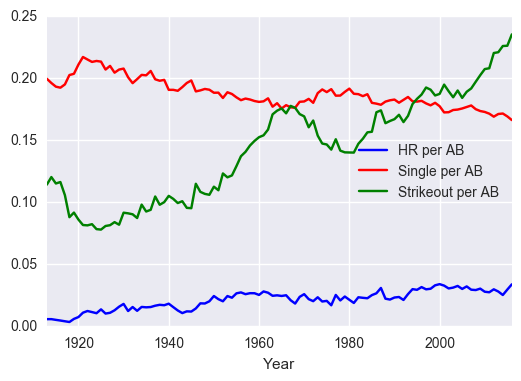

In [19]:

figure_1 = HR_AB_ratio.plot(color = 'b', label = 'HR per AB')
figure_1 = single_AB_ratio.plot(color = 'r', label = 'Single per AB')
figure_1 = SO_AB_ratio.plot(color = 'g', label = 'Strikeout per AB')
xlabel('Year')
figure_1.legend(loc = 'center right')

As can be seen from the plot, it seems at first glance that the notion is true that homeruns and strikeouts are positively correlated while singles and strikeouts are negatively correlated.  It is not totally convincing, as there are several spikes for all of the plots, though they all seem to follow some long-term trend.  In order to further explore this relationship, Pearson's correlation coefficient can be found with an accompanying scatter plot for the variables of interest.  This is performed below. 

Correlation coefficient = 0.828


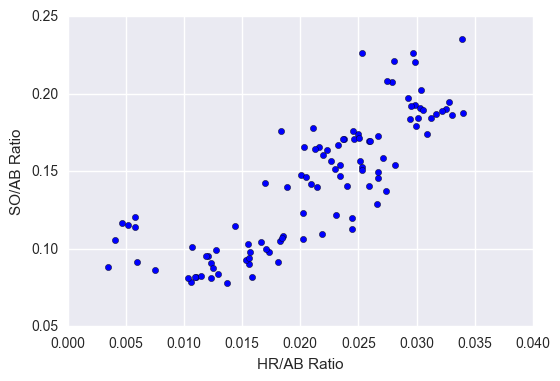

In [28]:
#Plot the relationships between homeruns and strikeouts
plt.scatter(HR_AB_ratio, SO_AB_ratio)
plt.xlabel("HR/AB Ratio")
plt.ylabel("SO/AB Ratio")
plt.xlim((0.00,0.04))
plt.ylim((0.05,0.25))
print'Correlation coefficient =', HR_AB_ratio.corr(SO_AB_ratio).round(3)

With this scatterplot and the accompanying correlation coefficient it is much more evident of the correlation between homeruns and strikeouts over the years.  For years in which several home runs were hit, there were also more corresponding strikeouts.  Alternatively, years in which the homeruns to at-bat ratio was slow, the strikeouts to at-bat ratio also tended to be low.  With a 0.828 correlation coefficient, the two variables are strongly correlated. Lets perform the same analysis on singles and strikeouts as well. 

Correlation coefficient = -0.925


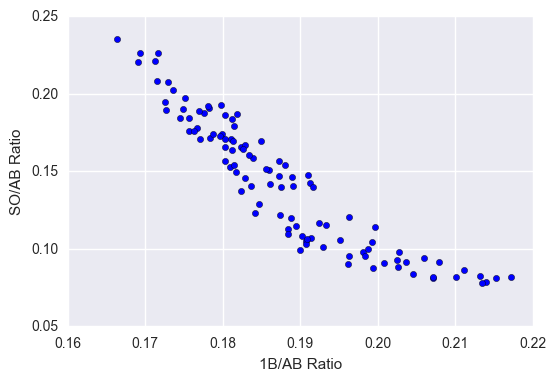

In [29]:
#Plot the relationship between singles and strikeouts
plt.scatter(single_AB_ratio, SO_AB_ratio)
plt.xlabel("1B/AB Ratio")
plt.ylabel("SO/AB Ratio")
plt.xlim((0.16,0.22))
plt.ylim((0.05,0.25))
print'Correlation coefficient =', single_AB_ratio.corr(SO_AB_ratio).round(3)

As expected, the negatively correlated relationship between singles and strikeouts seems to hold steady.  With an even stronger correlation of -0.925, the ratios between singles to at-bats and strikeouts to at-bats are strongly negatively correlated.  

> ***The second question to be explored involves what qualities make a starting pitcher valuable based upon their salary.***


In order to explore this, I used the average normalized salary, earned run average, total innings pitched, and strikeout to walks ratio for each starting pitcher from the resultant pitchers_with_salary data frame that was merged together in the data wrangling phase.  

Before I dive into further analysis, I wanted to outline why I chose the variables that I did.  Nearly all baseball analysts would agree that the most important statistic for a starting pitcher (or any pitcher for that matter) is their earned run average.  This is because it represents the average number of runs that can be "blamed" on the pitcher in a game and not on the fielding due to errors.  In a game where the objective is to outscore the other opponent, teams want pitchers that give up a small amount of earned runs per game to maximize their chances of winning.  In addition, I found it useful to include the strikeouts to walks ratio (K/BB) because strikeouts or walks alone do not represent the effectiveness of a pitcher like when they are combined.  For example, a pitcher may have an arsenal of pitches that often strikeout his opponent, but if he often misses the strikezone, he will also walk several hitters.  This is reflected in the K/BB ratio.  Lastly, I found it useful to include the total innings pitched since it signifies longevity in a pitcher's career.  If a pitcher has thrown thousands of innings throughout his career, it entails he is a valuable pitcher explaining why teams consistently pick him up on their respective teams. 

Now, lets find a few correlations among the variables and see if any worthy observations can be made.  It should be noted that when finding the plot or the correlation between variables using the ERA, I use its inverse.  This is because a low ERA is a good thing, whereas a high ERA is not something that is valued.  Since I want good values to be positively correlated, the inverse needs to be taken before they are compared.  

In [63]:
#final series extrapolated from the pitchers_with_salary data frame
final_salary = pitchers_with_salary['salary']
final_ERA = pitchers_with_salary['ERA']
final_IPouts = pitchers_with_salary['IPouts']
final_K_BB_ratio = pitchers_with_salary['K/game']/ pitchers_with_salary['BB/game']


Salary to total innings pitched correlation = 0.762


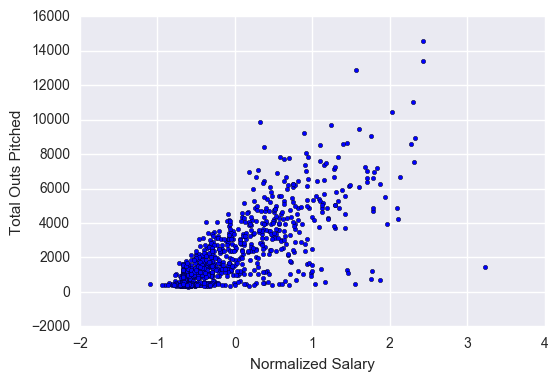

In [67]:
plt.scatter(final_salary, final_IPouts, s = 10)
plt.xlabel("Normalized Salary")
plt.ylabel("Total Outs Pitched")
print "Salary to total innings pitched correlation =", final_salary.corr(final_IPouts).round(3)

Salary to ERA correlation = 0.372


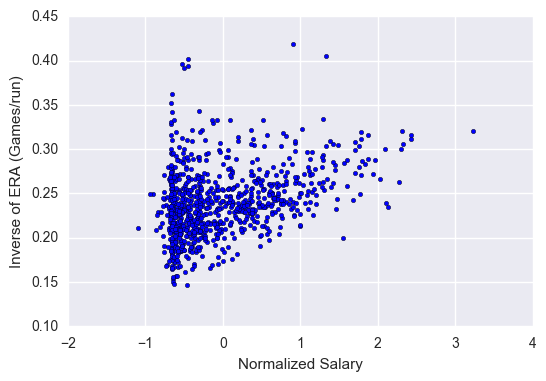

In [73]:
plt.scatter(final_salary, 1/final_ERA, s = 10)
plt.xlabel("Normalized Salary")
plt.ylabel("Inverse of ERA (Games/run)")
print "Salary to ERA correlation =", final_salary.corr(1/final_ERA).round(3)

Salary to K/BB correlation = 0.268


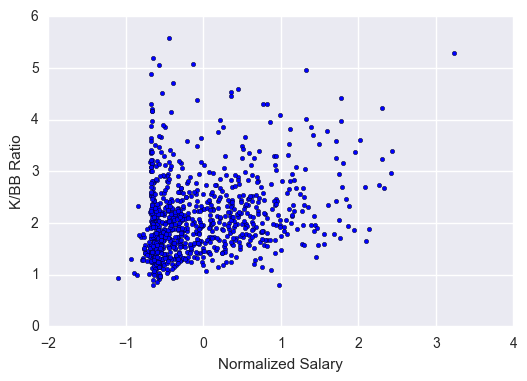

In [74]:
plt.scatter(final_salary, final_K_BB_ratio, s = 10)
plt.xlabel("Normalized Salary")
plt.ylabel("K/BB Ratio")
print "Salary to K/BB correlation =", final_salary.corr(K_BB_ratio).round(3)

To my surprise, it seems that the only statistic that strongly correlates with the salary of a pitcher is the total number of innings pitched.  ERA has a weak to moderate correlation, whereas the strikeout to walk ratio is even weaker.  I can think of a number of reasons for all of these observations.  

First, the fact that innings pitched and salary has such a strong correlation seems intuitive.  If a pitcher has a long career (i.e. has thrown several innings), he has proven his worth and becomes more valuable and deserves a higher salary (not to mention the difficulty in staying healthy over the years as a pitcher).  The reverse causal argument can also be made- if a pitcher is very valuable, he will end up throwing several innings and have a long career. Though the causation cannot be pinpointed, the correlation is clearly evident between the total innings pitched and the salary of a pitcher.  

On the other hand, the fact that ERA and salary were not more strongly correlated certainly struck me as odd.  I decided to look into the data a little bit more to get a better explanation as to why my intuition was off.  I first took a look at the top of the data frame by listing the pitchers in order by ascending ERA. 

In [78]:
pitchers_with_salary.sort_values('ERA', ascending=True).head(10)

,playerID,nameFirst,nameLast,salary,ERA,BB/game,K/game,IPouts
17474,tudorjo01,John,Tudor,0.910796,2.385000,1.867204,4.513364,2357.0
9057,kershcl01,Clayton,Kershaw,1.325768,2.465556,2.439205,9.807955,5280.0
7245,harvema01,Matt,Harvey,-0.444061,2.490000,1.664551,9.277425,1103.0
5289,fernajo02,Jose,Fernandez,-0.527805,2.525000,2.864789,11.154930,1065.0
4667,duchsju01,Justin,Duchscherer,-0.451542,2.540000,2.160000,6.035294,425.0
16259,sosajo02,Jorge,Sosa,-0.494791,2.550000,4.298507,5.708955,402.0
4151,degroja01,Jacob,deGrom,-0.661549,2.756667,2.196801,9.237830,1438.0
14557,roarkta01,Tanner,Roark,-0.671064,2.840000,2.466558,6.827080,1226.0
14634,robinro01,Ron,Robinson,-0.301932,2.910000,2.244944,3.458427,445.0
16898,syndeno01,Noah,Syndergaard,-0.654792,2.920000,1.996004,10.357642,1001.0


The first thing that struck me as odd was that someone had a better ERA than Clayton Kershaw.  I decided to do a little investigating and found that Tudor's real career ERA was 3.12 (still, a very impressive ERA), much higher than Kershaw's 2.47.  This was because the salary data excluded data pre-1985 and Tudor began his pitching career in 1979.  The abridged data set only included his primetime years in which he was able to lower his overall ERA with several years of success towards the end of his career.  

Furthermore, a quick glance at the top 10 ERAs shows Matt Harvey, Jacob DeGrom, and Noah Syndergaard (GO METS) as all below the mean in salaries over their careers.  This is because they are young and are still in the beginning of their careers, hoping to prove themselves to ultimately secure a more lucrative contract.  This means that the data analyzed seems to be skewed to represent young player's with good ERAs as undervalued and older players in the height of their careers as overvalued as their early career is not documented.  

An interesting exercise would be to examine the impact of the ERA of the first few years of starter's career and the relative increase in salary they get as a result of their initial performance.  This would better take into account the impact of ERA on a pitcher's salary, as their value is often evaluated based on their future potential, not just their current abilities.  